# Demo a Single Simulation Run

In this notebook, we demonstrate a single run of our risk simulation:
- We show the logs of agent actions (e.g. liquidations, arbitrages, peg keeper updates).
- We show a timeseries view of the metrics we collect on agents and the crvusd contracts.
- We plot and analyze results

### Some current limitations
- We are only modeling a single LLAMMA. We are working to incorporate all LLAMMAs to consider hollistic systemic risk.
- We are not considering some key Curve pools yet. For example, we are not explicitly modeling the TriCrypto-ng pools that feed into LLAMMA's oracle.

In [1]:
from copy import deepcopy
import pandas as pd
from src.sim.scenario import Scenario
from src.sim.processing import SingleSimProcessor
from src.metrics import DEFAULT_METRICS
from src.logging import get_logger
from src.configs import MODELLED_MARKETS

logger = get_logger(__name__)

pd.set_option("display.max_columns", None)
%load_ext autoreload
%autoreload 2

In [2]:
# Generate markets and prices

config = "severe vol"
scenario_ = Scenario(config, MODELLED_MARKETS)
print(
    f"Running {scenario_.num_steps} steps with frequency {scenario_.pricepaths.config['freq']}."
)

[INFO][20:56:19][src.sim.scenario]-47871: Fetching wbtc market from subgraph
[INFO][20:56:23][src.sim.scenario]-47871: Market snapshot as 2024-01-16 22:24:59
[INFO][20:56:23][src.sim.scenario]-47871: Bands snapshot as 2024-01-15 19:58:47
[INFO][20:56:23][src.sim.scenario]-47871: Users snapshot as 2024-01-16 23:17:47
[INFO][20:56:23][src.sim.scenario]-47871: Fetching weth market from subgraph
[INFO][20:56:26][src.sim.scenario]-47871: Market snapshot as 2024-01-16 22:24:59
[INFO][20:56:26][src.sim.scenario]-47871: Bands snapshot as 2024-01-15 19:58:47
[INFO][20:56:26][src.sim.scenario]-47871: Users snapshot as 2024-01-16 23:17:47
[INFO][20:56:26][src.sim.scenario]-47871: Fetching sfrxeth market from subgraph
[INFO][20:56:29][src.sim.scenario]-47871: Market snapshot as 2024-01-16 22:24:59
[INFO][20:56:29][src.sim.scenario]-47871: Bands snapshot as 2024-01-15 19:58:47
[INFO][20:56:29][src.sim.scenario]-47871: Users snapshot as 2024-01-16 23:17:47
[INFO][20:56:29][src.sim.scenario]-47871: F

Running 288 steps with frequency 5min.


In [3]:
scenario = deepcopy(scenario_)
scenario.prepare_for_run()

In [4]:
scenario.llammas[0].admin_fees_x, scenario.llammas[0].admin_fees_y

(0, 0)

In [5]:
processor = SingleSimProcessor(scenario, DEFAULT_METRICS)

In [6]:
import cProfile
import pstats

with cProfile.Profile() as pr:
    for sample in scenario.pricepaths:
        # print(sample.timestamp.time())
        scenario.prepare_for_trades(sample)  # update prices/timestamps
        scenario.perform_actions(sample)  # arbitrage, liquidate, update
        processor.update(sample.timestamp, inplace=True)  # collect metrics

stats = pstats.Stats(pr)
stats.sort_stats(pstats.SortKey.CUMULATIVE)
stats.print_stats()

         284333322 function calls (284175535 primitive calls) in 116.381 seconds

   Ordered by: cumulative time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
      288    0.001    0.000  103.298    0.359 /Users/tncintra/Desktop/root/xenophon/clients/curve/crvUSDrisk/src/sim/scenario.py:574(perform_actions)
      288    0.004    0.000   95.237    0.331 /Users/tncintra/Desktop/root/xenophon/clients/curve/crvUSDrisk/src/agents/arbitrageur.py:31(arbitrage)
      996    0.106    0.000   95.042    0.095 /Users/tncintra/Desktop/root/xenophon/clients/curve/crvUSDrisk/src/agents/arbitrageur.py:75(find_best_arbitrage)
    55776    0.106    0.000   94.747    0.002 /Users/tncintra/Desktop/root/xenophon/clients/curve/crvUSDrisk/src/trades/cycle.py:139(optimize)
    45544    0.165    0.000   76.798    0.002 /Users/tncintra/Desktop/root/xenophon/clients/curve/crvUSDrisk/src/trades/cycle.py:271(_optimize_mem)
    39484    0.224    0.000   74.913    0.002 /Users/tncintra/Des

In [7]:
results = processor.process()

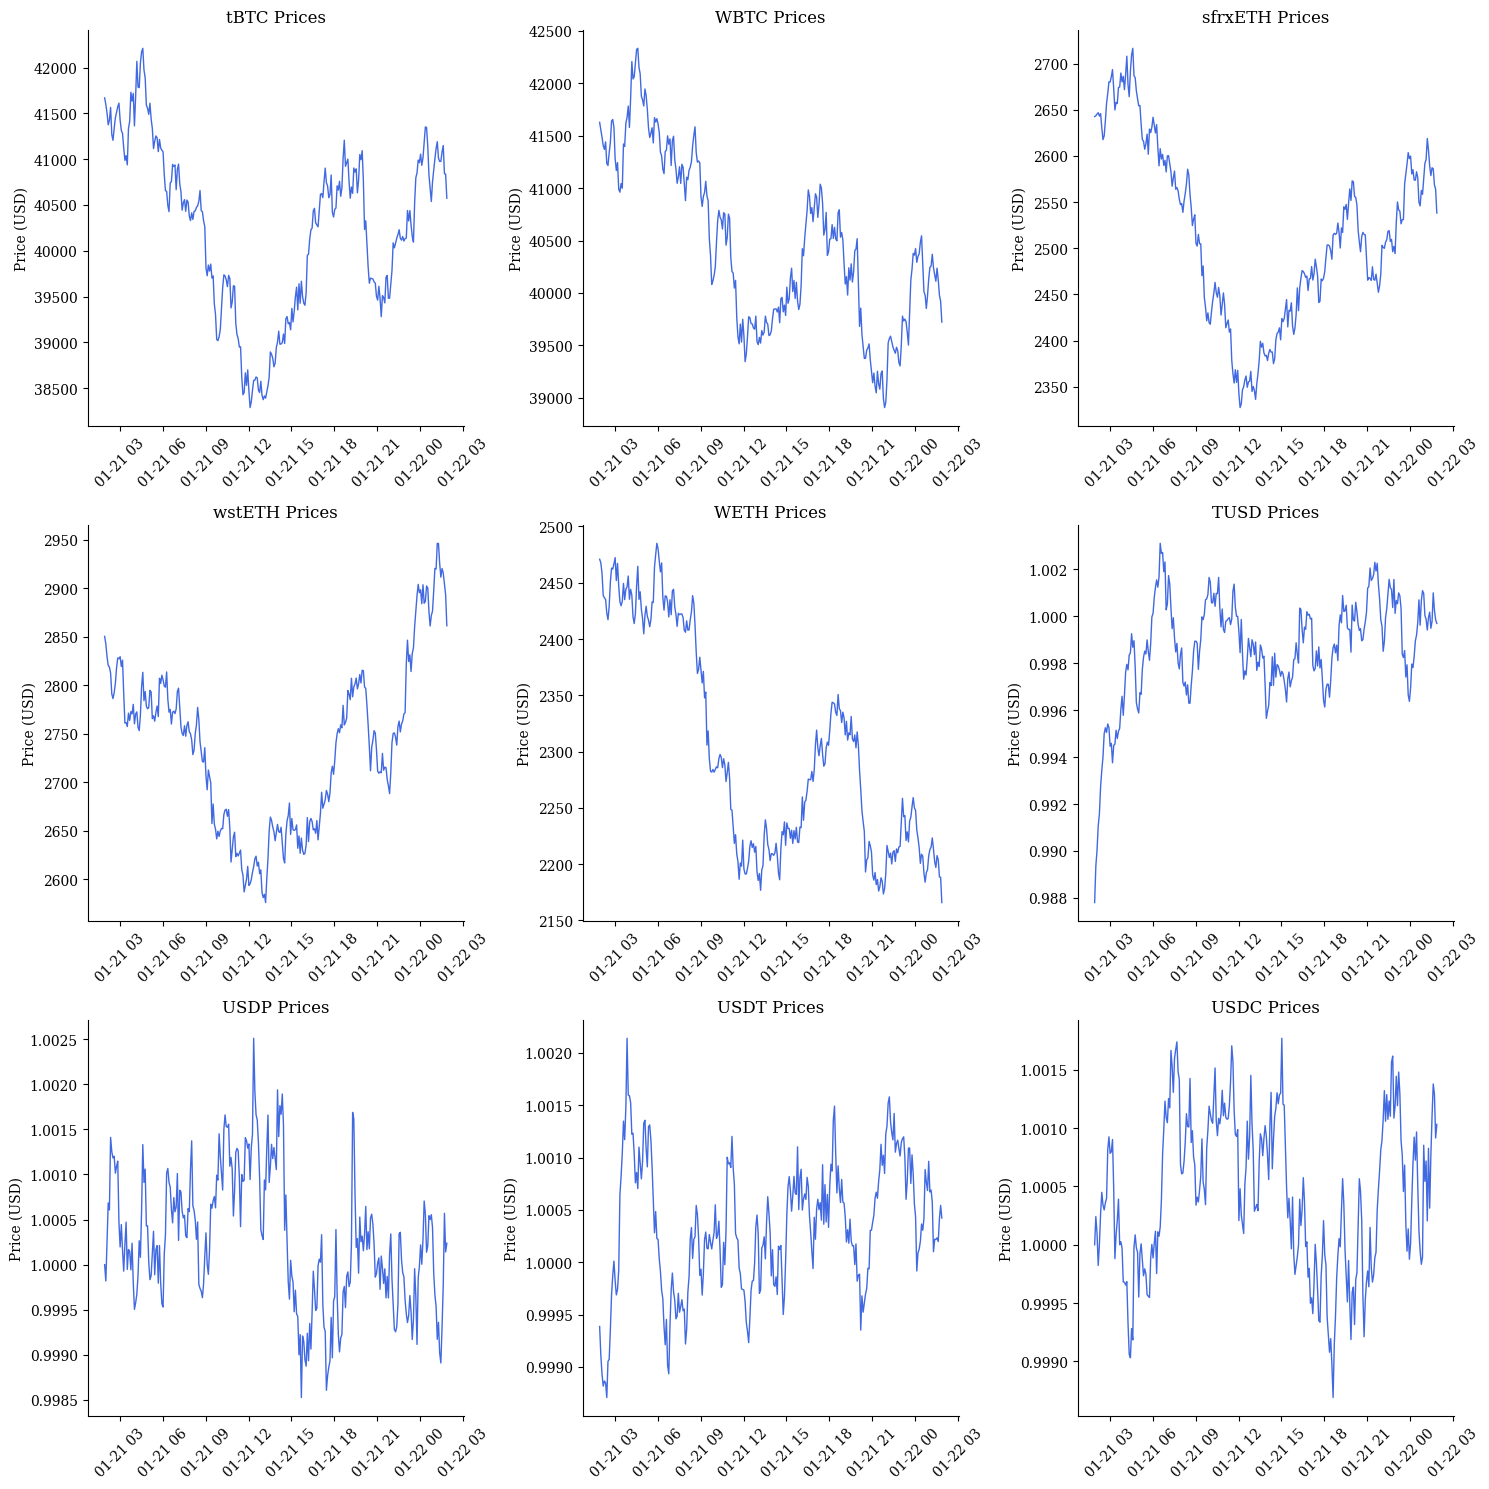

In [8]:
results.plot_prices()

In [9]:
df = results.df
# df.to_csv("../data/results.csv")
df.tail()

,Bad Debt Pct,Bad Debt Pct on Controller Wbtc,Bad Debt Pct on Controller Weth,Bad Debt Pct on Controller Sfrxeth,Bad Debt Pct on Controller Wsteth,System Health,System Health on Controller Wbtc,System Health on Controller Weth,System Health on Controller Sfrxeth,System Health on Controller Wsteth,Borrower Loss Pct,Hard Liquidation Loss Pct,Soft Liquidation Loss Pct,Value Leakage,Keeper Profit,Keeper Count,Keeper Profit on Pk Crvusd/Tusd,Keeper Count on Pk Crvusd/Tusd,Keeper Profit on Pk Crvusd/Usdp,Keeper Count on Pk Crvusd/Usdp,Keeper Profit on Pk Crvusd/Usdc,Keeper Count on Pk Crvusd/Usdc,Keeper Profit on Pk Crvusd/Usdt,Keeper Count on Pk Crvusd/Usdt,Liquidator Profit,Liquidator Count,Liquidator Profit on Controller Wbtc,Liquidator Count on Controller Wbtc,Liquidator Profit on Controller Weth,Liquidator Count on Controller Weth,Liquidator Profit on Controller Sfrxeth,Liquidator Count on Controller Sfrxeth,Liquidator Profit on Controller Wsteth,Liquidator Count on Controller Wsteth,Arbitrageur Profit,Arbitrageur Count,Aggregator Price,Stableswap Crvusd_Tusd Price,Stableswap Crvusd_Usdp Price,Stableswap Crvusd_Usdc Price,Stableswap Crvusd_Usdt Price,Debt Liquidated Pct,Debt Liquidated Pct on Controller Wbtc,Debt Liquidated Pct on Controller Weth,Debt Liquidated Pct on Controller Sfrxeth,Debt Liquidated Pct on Controller Wsteth,PK Debt,Pk Crvusd/Tusd Debt,Pk Crvusd/Usdp Debt,Pk Crvusd/Usdc Debt,Pk Crvusd/Usdt Debt,Total crvUSD Liquidity,Stableswap Crvusd_Tusd crvUSD Liquidity,Stableswap Crvusd_Usdp crvUSD Liquidity,Stableswap Crvusd_Usdc crvUSD Liquidity,Stableswap Crvusd_Usdt crvUSD Liquidity,Total Debt,Controller Wbtc Total Debt,Controller Weth Total Debt,Controller Sfrxeth Total Debt,Controller Wsteth Total Debt,Worst Oracle Error Pct,Llamma Wbtc Price,Llamma Wbtc Oracle Price,Llamma Wbtc Oracle Error Pct,Llamma Weth Price,Llamma Weth Oracle Price,Llamma Weth Oracle Error Pct,Llamma Sfrxeth Price,Llamma Sfrxeth Oracle Price,Llamma Sfrxeth Oracle Error Pct,Llamma Wsteth Price,Llamma Wsteth Oracle Price,Llamma Wsteth Oracle Error Pct,Net LLAMMA Profit Pct,LLAMMA Profit on Llamma Wbtc Pct,LLAMMA Profit on Llamma Weth Pct,LLAMMA Profit on Llamma Sfrxeth Pct,LLAMMA Profit on Llamma Wsteth Pct
timestamp,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2024-01-22 01:31:33,0.0,0.0,0.0,0.0,0.0,0.947000,1.144552,0.597269,1.440091,0.765908,0.301797,0.203667,0.098130,300074.082521,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,205652.290813,13,42801.830709,7,139466.223087,4,0.0,0,23384.237017,2,94421.791708,701,0.999485,0.999580,1.000014,0.999447,0.999405,2.469869,2.055828,10.506947,0.0,0.525529,3.896119e+06,3.440977e+06,0.0,0.0,455142.360487,4.331827e+07,5.195146e+06,2.421485e+06,1.730268e+07,1.839897e+07,1.006561e+08,3.628868e+07,1.337883e+07,1.000283e+07,4.098573e+07,0.057660,40236.234119,40213.398602,0.057660,2213.843167,2206.259182,0.057660,3167.513210,2585.628414,0.057660,3045.004817,2918.434904,0.057660,0.329319,0.682255,0.216916,0.0,0.132663
2024-01-22 01:36:33,0.0,0.0,0.0,0.0,0.0,0.942837,1.138057,0.594338,1.438822,0.762700,0.301797,0.203667,0.098130,300159.644738,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,205652.290813,13,42801.830709,7,139466.223087,4,0.0,0,23384.237017,2,94507.353925,703,0.999478,0.999553,1.000063,0.999285,0.999553,2.469869,2.055828,10.506947,0.0,0.525529,3.896119e+06,3.440977e+06,0.0,0.0,455142.360487,4.331825e+07,5.224882e+06,2.391747e+06,1.784550e+07,1.785611e+07,1.006562e+08,3.628871e+07,1.337884e+07,1.000284e+07,4.098578e+07,0.069011,39892.072715,40097.900723,0.069011,2202.370344,2202.438837,0.069011,3162.799378,2584.346861,0.069011,3029.485967,2913.470481,0.069011,0.329319,0.682255,0.216916,0.0,0.132663
2024-01-22 01:41:33,0.0,0.0,0.0,0.0,0.0,0.935049,1.130407,0.588574,1.421122,0.755502,0.315975,0.217793,0.098182,314559.512349,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,220012.685796,15,44899.151114,8,151729.297665,5,0.0,0,23384.237017,2,94546.826553,705,0.999474,0.999553,1.000063,0.999289,0.999583,2.630508,2.128335

In [10]:
results.metric_map

{'BadDebtMetric': 0,
 'SystemHealthMetric': 1,
 'BorrowerLossMetric': 2,
 'ValueLeakageMetric': 3,
 'PegStrengthMetric': 4,
 'LiquidationsMetric': 5,
 'PegKeeperMetric': 6,
 'LiquidityMetric': 7,
 'DebtMetric': 8,
 'PriceMetric': 9,
 'ProfitsMetric': 10}

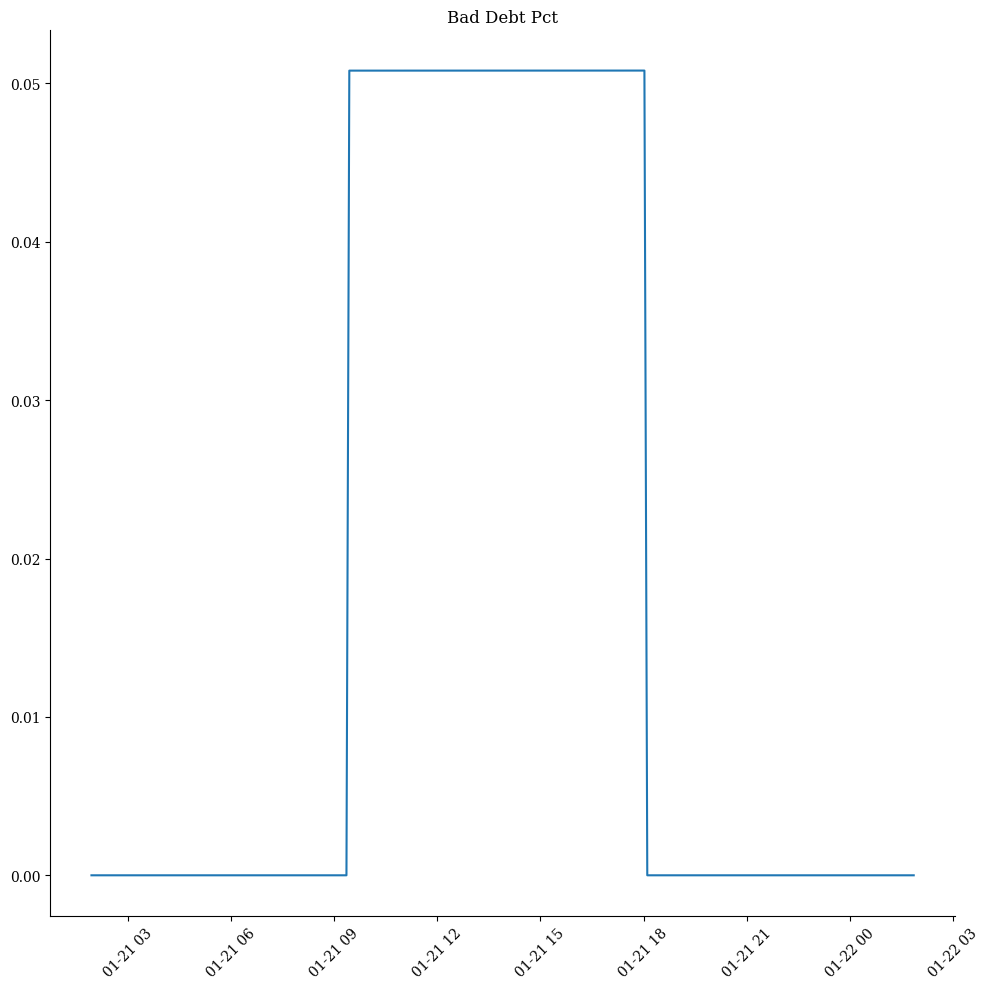

<Axes: title={'center': 'Bad Debt Pct'}>

In [11]:
results.plot_metric(0, show=True)

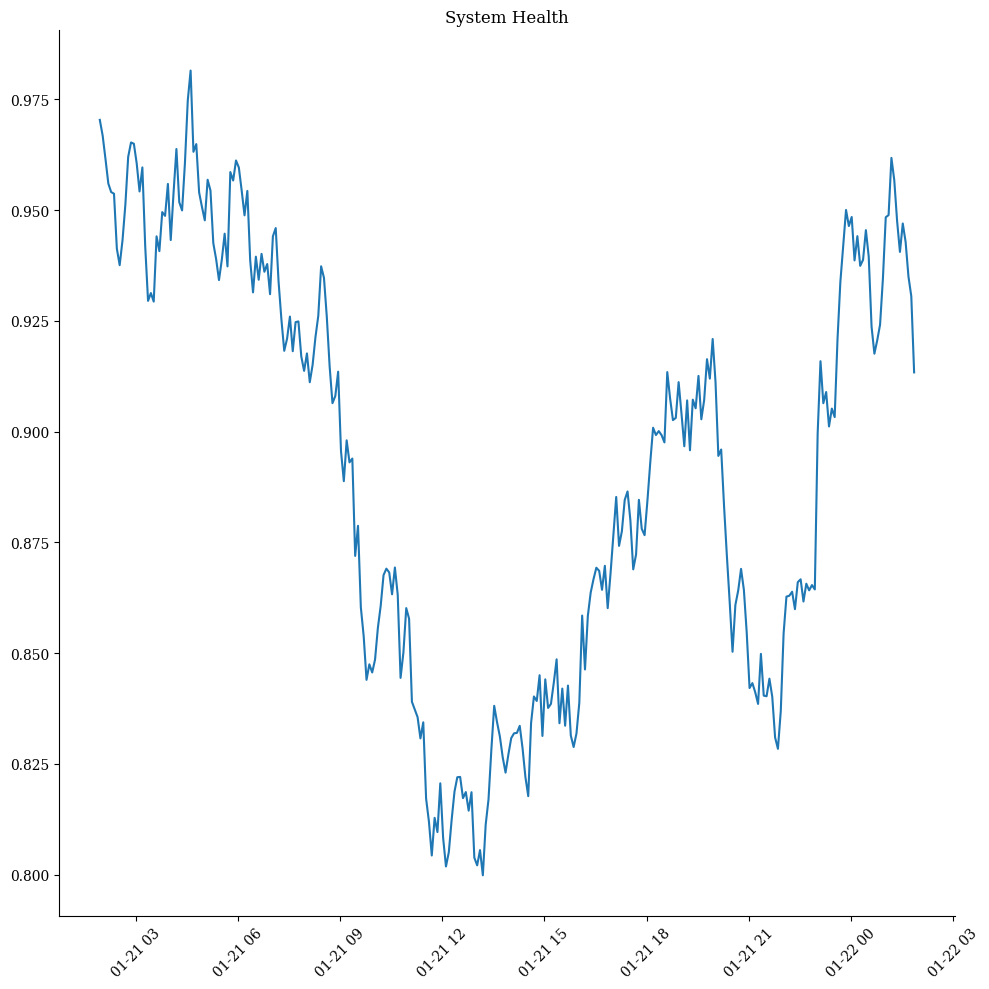

<Axes: title={'center': 'System Health'}>

In [12]:
results.plot_metric(1, show=True)

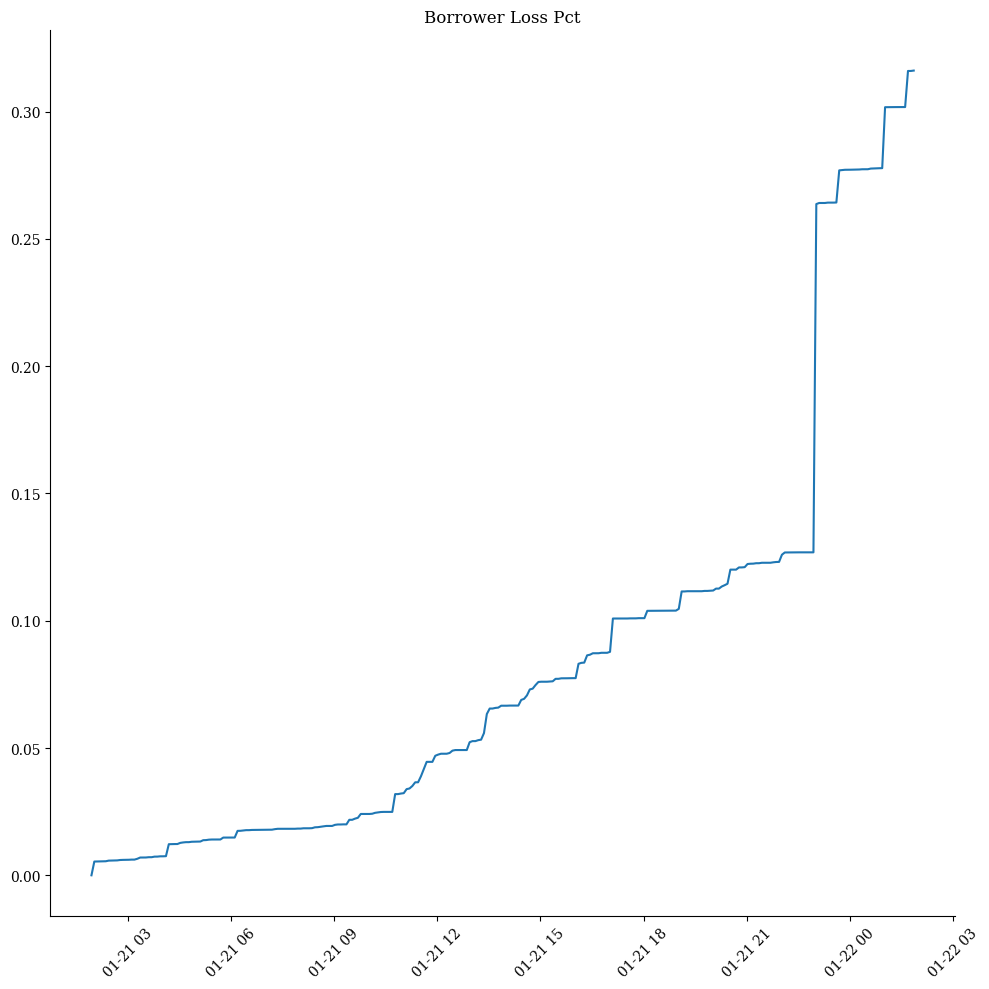

<Axes: title={'center': 'Borrower Loss Pct'}>

In [13]:
results.plot_metric(2, show=True)

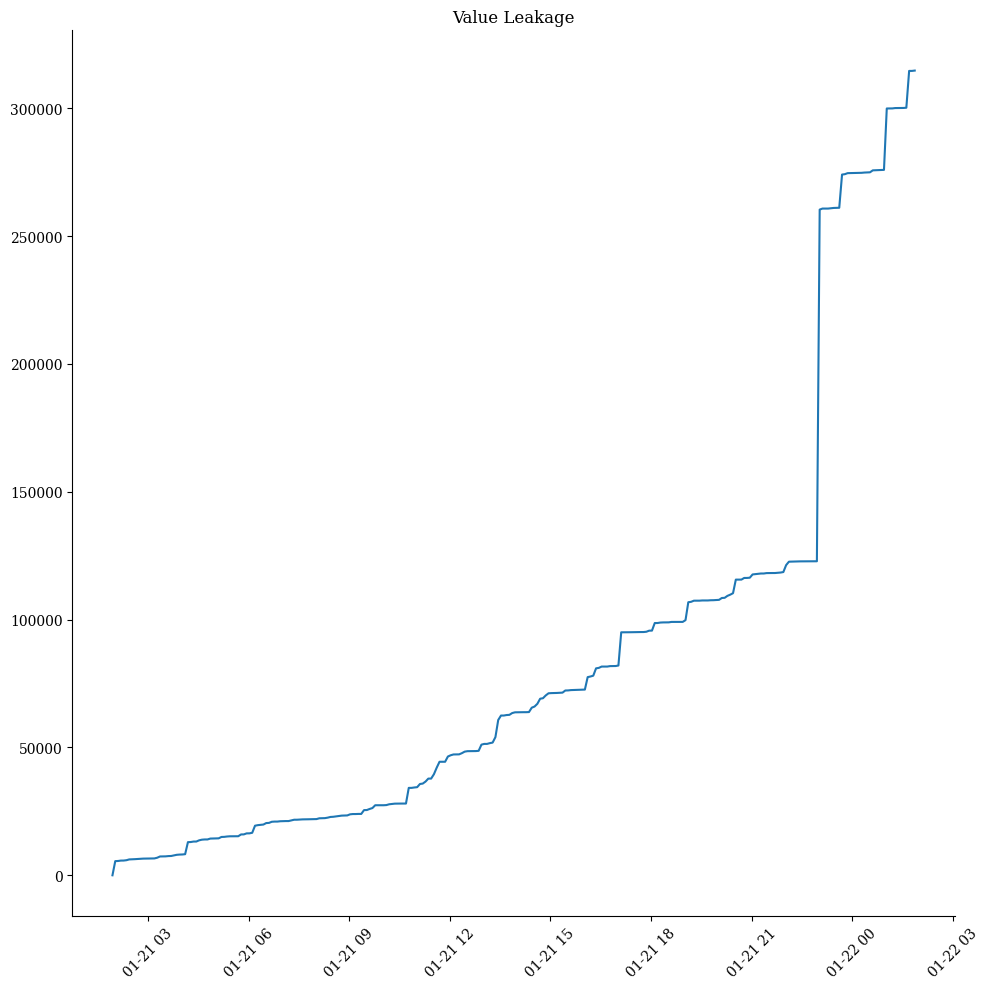

<Axes: title={'center': 'Value Leakage'}>

In [14]:
results.plot_metric(3, show=True)  # seems broken from crvusdsim

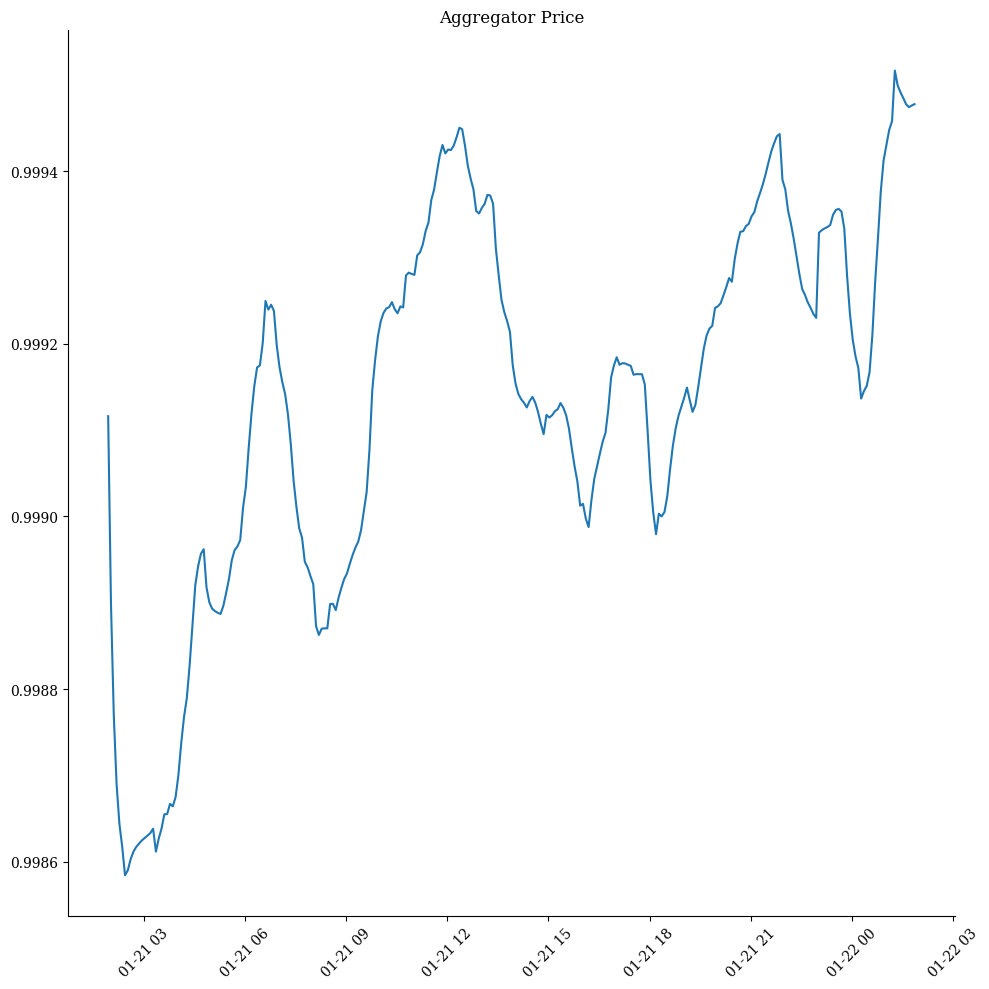

<Axes: title={'center': 'Aggregator Price'}>

In [15]:
results.plot_metric(4, show=True)

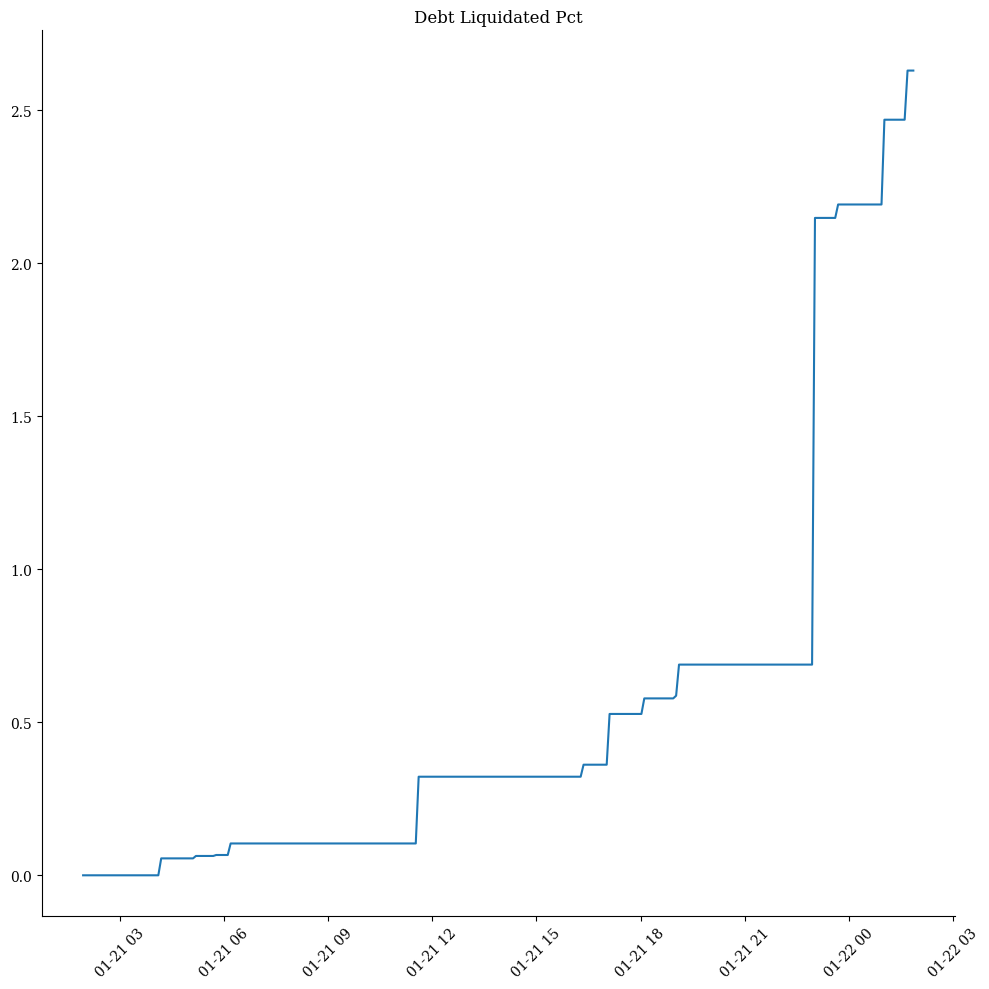

<Axes: title={'center': 'Debt Liquidated Pct'}>

In [16]:
results.plot_metric(5, show=True)

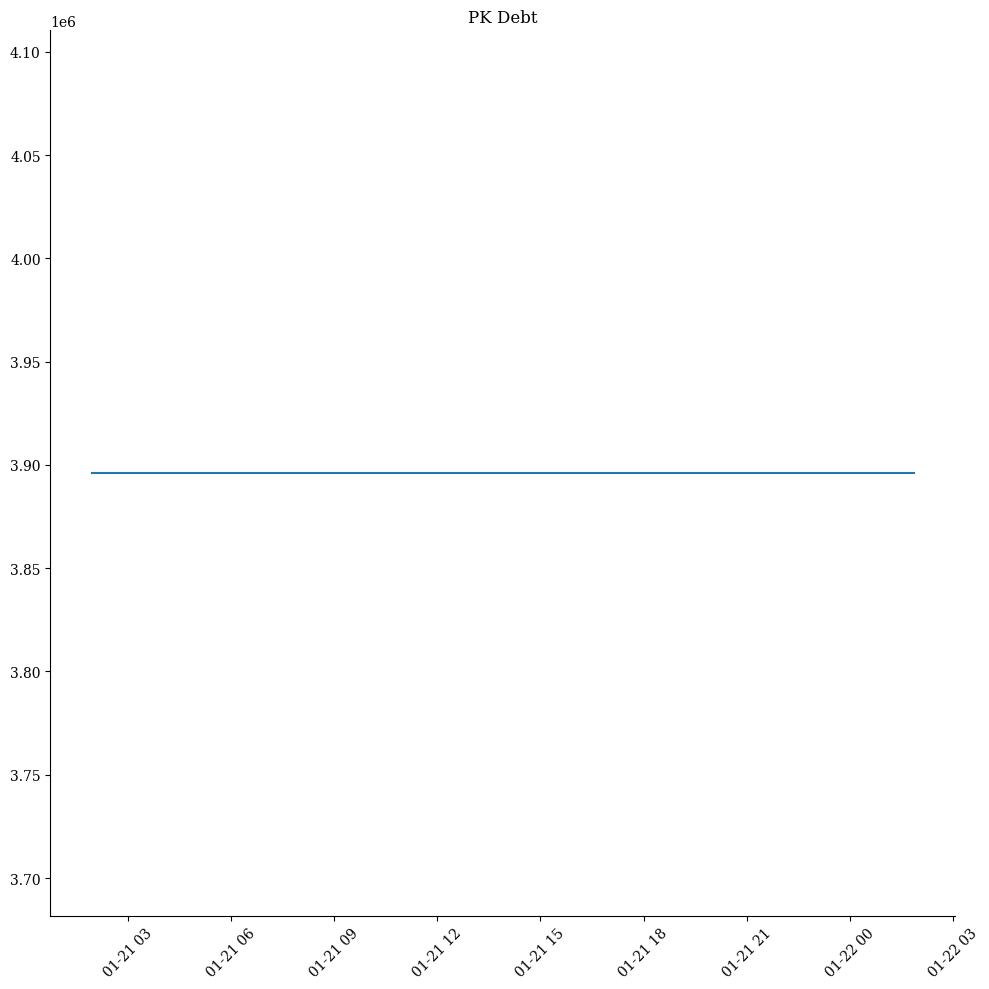

<Axes: title={'center': 'PK Debt'}>

In [17]:
results.plot_metric(6, show=True)

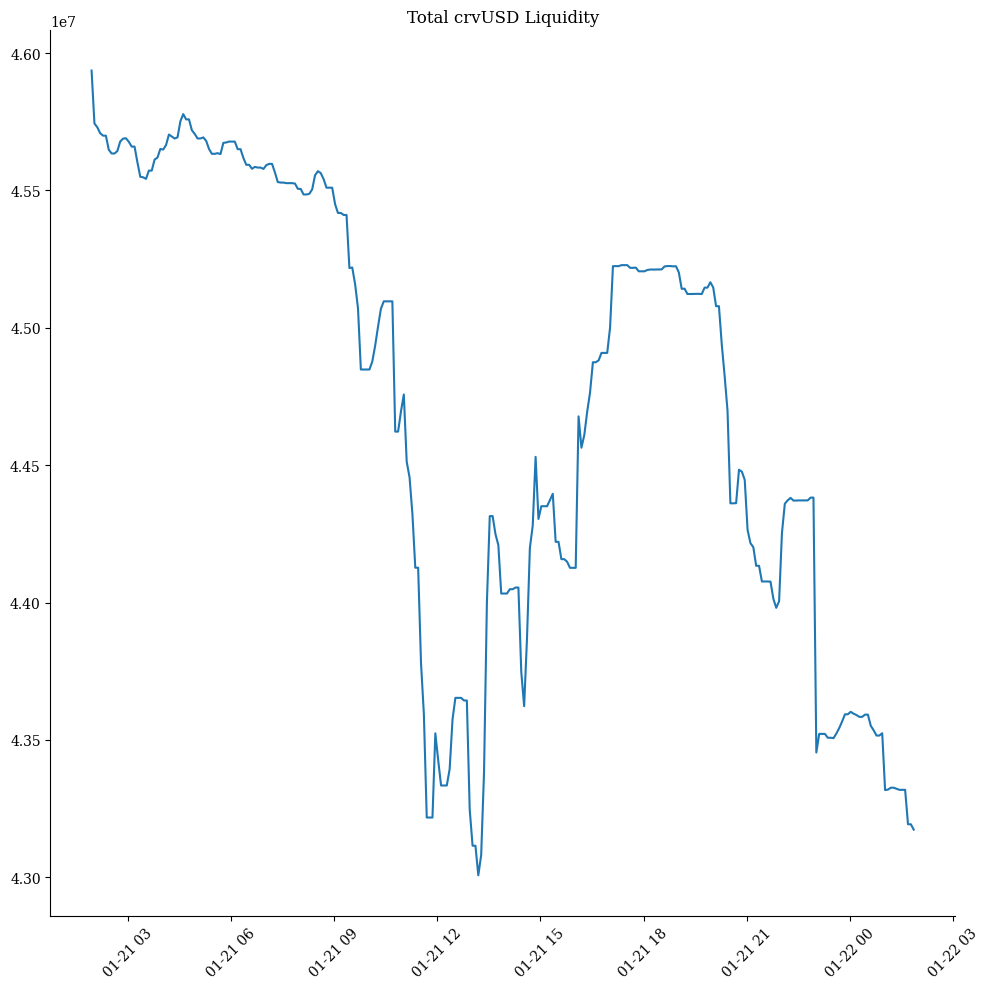

<Axes: title={'center': 'Total crvUSD Liquidity'}>

In [18]:
results.plot_metric(7, show=True)

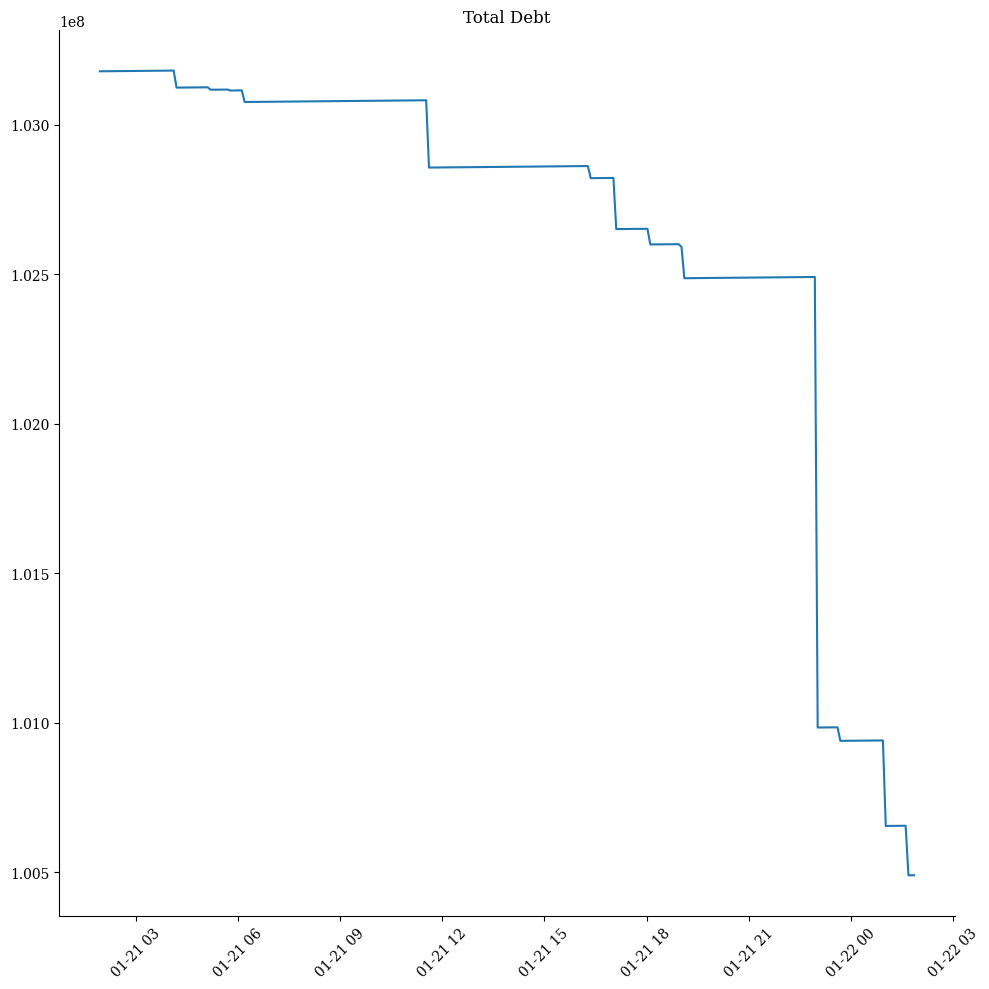

<Axes: title={'center': 'Total Debt'}>

In [19]:
results.plot_metric(8, show=True)

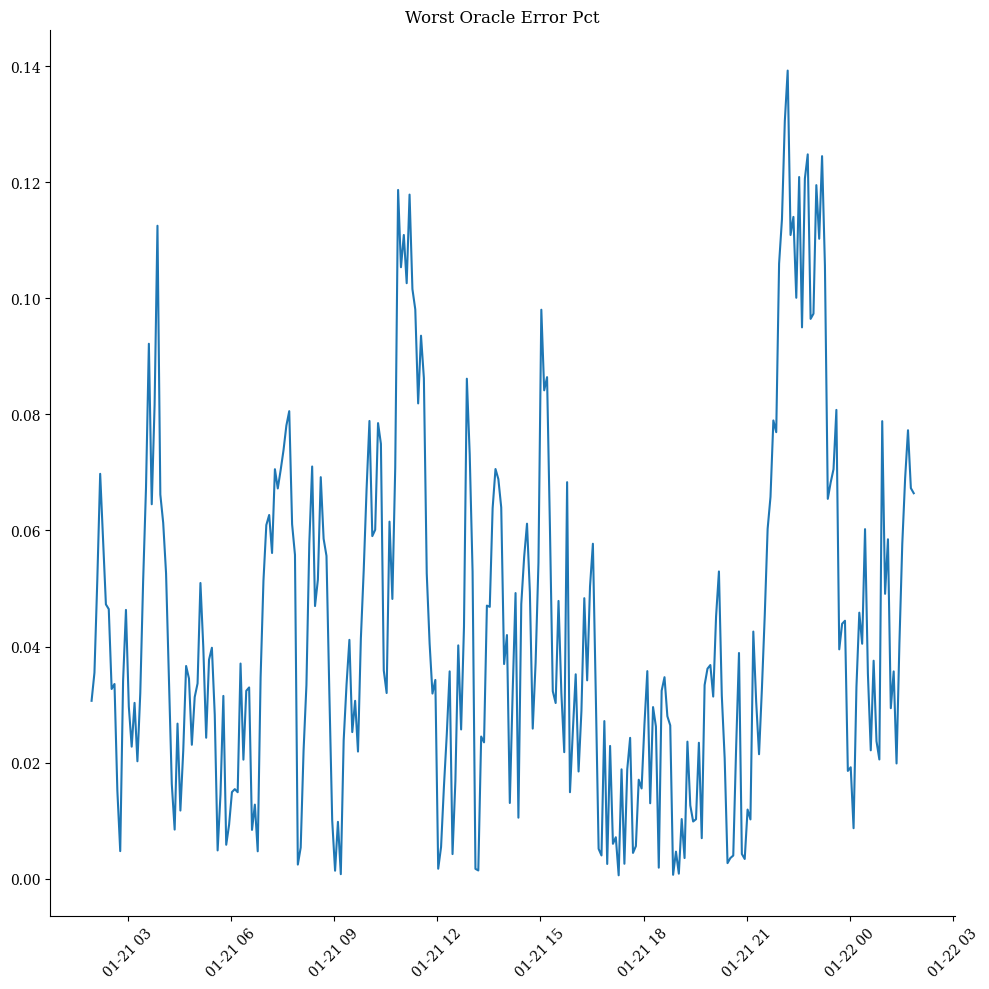

<Axes: title={'center': 'Worst Oracle Error Pct'}>

In [20]:
results.plot_metric(9, show=True)

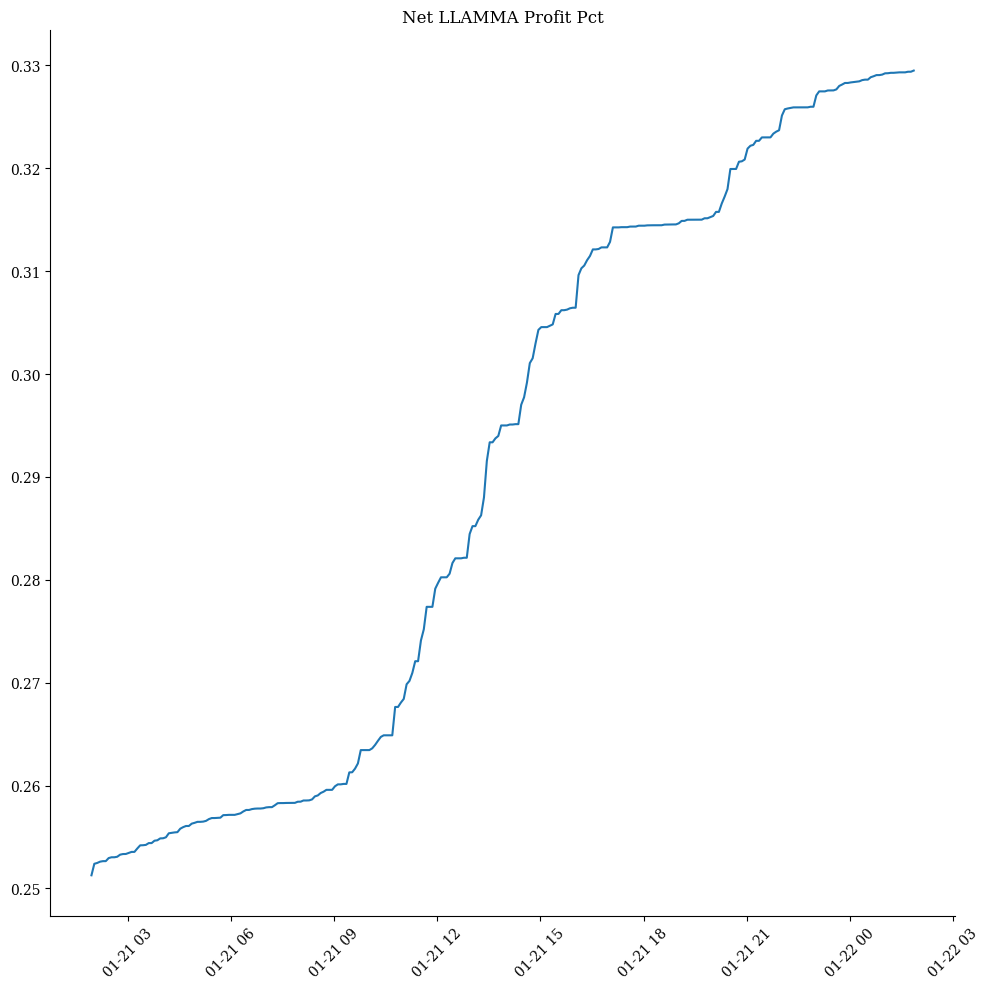

<Axes: title={'center': 'Net LLAMMA Profit Pct'}>

In [21]:
results.plot_metric(10, show=True)

In [22]:
for llamma in scenario.llammas:
    print(
        llamma.name,
        sum(llamma.bands_fees_x.values()),
        sum(llamma.bands_fees_y.values()),
    )

Curve.fi Stablecoin WBTC 246590593341056788078776 156687193199999993
Curve.fi Stablecoin WETH 18226907592767152936875 6420779347189465878
Curve.fi Stablecoin sfrxETH 0 0
Curve.fi Stablecoin wstETH 38679967650095473135855 6008379476908943589


<Axes: xlabel='timestamp'>

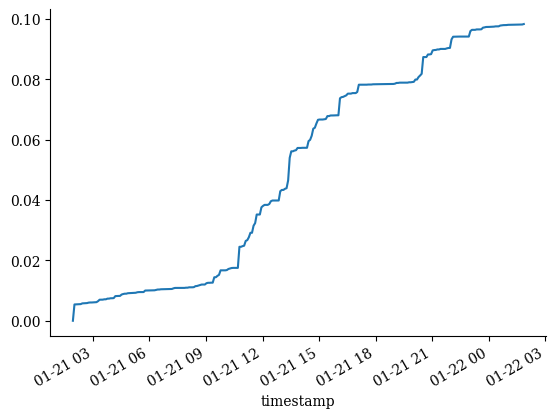

In [23]:
results.df["Soft Liquidation Loss Pct"].plot()

In [24]:
scenario.llammas[0].admin_fees_x, scenario.llammas[0].admin_fees_y

(247485, 0)

In [25]:
summary = results.summary.T
summary.columns = ["value"]
summary

,value
Bad Debt Pct Max,0.050810
Bad Debt Pct On Controller Wbtc Max,0.000000
Bad Debt Pct On Controller Weth Max,0.350761
Bad Debt Pct On Controller Sfrxeth Max,0.000000
Bad Debt Pct On Controller Wsteth Max,0.000000
...,...
Net Llamma Profit Pct Mean,0.290478
Llamma Profit On Llamma Wbtc Pct Mean,0.663120
Llamma Profit On Llamma Weth Pct Mean,0.094745
Llamma Profit On Llamma Sfrxeth Pct Mean,0.000000
